## Imports: libraries and dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
df = pd.read_csv('../../dataset/KAG_energydata_complete.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


Standardize the dataset

In [3]:
scaler = StandardScaler()
target_series = df['Appliances']
target_series_scaled = scaler.fit_transform(target_series.values.reshape(-1, 1)).flatten()

In [4]:
split_ratio = 0.8
split_index = int(len(target_series_scaled) * split_ratio)
train_series = target_series_scaled[:split_index]
test_series = target_series_scaled[split_index:]

print(f'Training data shape: {train_series.shape}')
print(f'Test data shape: {test_series.shape}')

Training data shape: (15788,)
Test data shape: (3947,)


## Arima model

In [5]:
predictions = []
actuals = []
batch_size = 200

In [6]:
for i in range(0, len(test_series), batch_size):
    end_index = i + batch_size if i + batch_size < len(test_series) else len(test_series)
    train_window = np.concatenate([train_series, test_series[:i]])
    
    # Fit ARIMA model
    model = ARIMA(train_window, order=(2, 0, 2))
    model_fit = model.fit()
    
    # Forecast
    forecast = model_fit.forecast(steps=end_index - i)
    predictions.extend(forecast)
    actuals.extend(test_series[i:end_index])

In [7]:
# Inverse scaling
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

In [8]:
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(actuals, predictions)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared:', r2)

Mean Absolute Error (MAE): 52.02338860724985
Mean Squared Error (MSE): 8200.079500814549
Root Mean Squared Error (RMSE): 90.55429035012394
R-squared: 0.010609832744544634


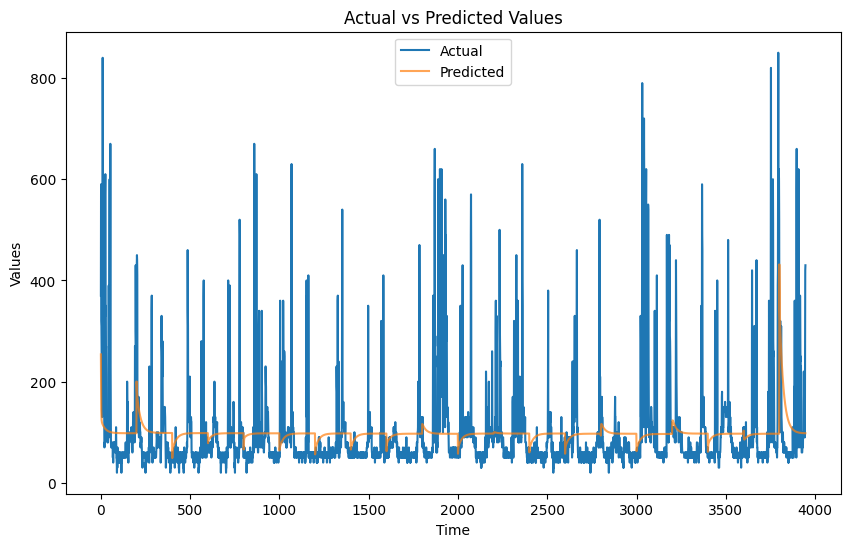

In [9]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()